# Desafío 2 - Solución

## Paola Cartalá

### Consigna Desafío 2

**1**. Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.

**2**. Probar términos de interés y explicar similitudes en el espacio de embeddings.

**3**. Intentar plantear y probar tests de analogías.

**4**. Graficar los embeddings resultantes.

**5**. Sacar conclusiones.

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 975.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
open

#### Obtención y procesamiento del dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List, Dict, Tuple

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import unicodedata

import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import requests

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [2]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [4]:
class NewsDatasetLoader:
    """Descarga y preprocesa datasets de noticias en inglés"""

    def __init__(self):
        self.dataset_urls = {
            'bbc_news': 'https://raw.githubusercontent.com/suraj-deshmukh/BBC-News-Classification/master/BBC%20News%20Train.csv'
        }

    def download_bbc_news(self) -> List[str]:
        """Descarga el dataset de BBC News"""
        try:
            import requests
            url = self.dataset_urls['bbc_news']
            print(f"Descargando dataset de BBC News desde: {url}")

            response = requests.get(url, timeout=30)

            if response.status_code == 200:
                with open('bbc_news.csv', 'wb') as f:
                    f.write(response.content)

                df = pd.read_csv('bbc_news.csv')
                print(f"✓ Dataset descargado exitosamente: {len(df)} artículos")

                news_texts = df['Text'].head(200).tolist()
                print(f"✓ Usando {len(news_texts)} artículos para entrenamiento")
                return news_texts
            else:
                raise Exception(f"HTTP error {response.status_code}")

        except Exception as e:
            print(f"✗ Error descargando dataset de BBC News: {e}")
            return []

    def download_sklearn_newsgroups(self) -> List[str]:
        """Descarga el dataset 20 Newsgroups usando sklearn"""
        try:
            from sklearn.datasets import fetch_20newsgroups

            categories = [
                'sci.space', 'sci.electronics', 'sci.med',
                'rec.sport.baseball', 'rec.sport.hockey',
                'talk.politics.guns', 'talk.politics.mideast',
                'comp.graphics', 'comp.sys.mac.hardware'
            ]

            print("Descargando dataset 20 Newsgroups...")
            newsgroups = fetch_20newsgroups(
                subset='train',
                categories=categories,
                remove=('headers', 'footers', 'quotes')
            )

            print(f"✓ Dataset 20 Newsgroups cargado: {len(newsgroups.data)} documentos")
            print(f"✓ Categorías: {newsgroups.target_names}")

            texts = [text for text in newsgroups.data if len(text.split()) > 20][:150]
            print(f"✓ Usando {len(texts)} artículos filtrados para entrenamiento")
            return texts

        except Exception as e:
            print(f"✗ Error descargando dataset 20 Newsgroups: {e}")
            return []

dataset_loader = NewsDatasetLoader()

print("=== DESCARGA DE DATASET ===")
print("Intentando descargar dataset real de noticias en inglés...")

print("\nOpción 1: Probando 20 Newsgroups (sklearn)...")
news_texts = dataset_loader.download_sklearn_newsgroups()

if len(news_texts) < 10:
    print("\nOpción 2: Probando BBC News (online)...")
    news_texts = dataset_loader.download_bbc_news()

if len(news_texts) < 10:
    print("✗ Falló la descarga de cualquier dataset.")
    news_texts = []
else:
    print(f"\n✓ Dataset final cargado: {len(news_texts)} documentos")

=== DESCARGA DE DATASET ===
Intentando descargar dataset real de noticias en inglés...

Opción 1: Probando 20 Newsgroups (sklearn)...
Descargando dataset 20 Newsgroups...
✓ Dataset 20 Newsgroups cargado: 5247 documentos
✓ Categorías: ['comp.graphics', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics', 'sci.med', 'sci.space', 'talk.politics.guns', 'talk.politics.mideast']
✓ Usando 150 artículos filtrados para entrenamiento

✓ Dataset final cargado: 150 documentos


### 1. Preprocesamiento del texto

In [5]:
class TextPreprocessor:
    """Clase para preprocesamiento de texto en inglés"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.update(['said', 'would', 'could', 'also', 'one', 'two', 'may', 'new', 'first', 'last'])

    def clean_text(self, text: str) -> str:
        """Limpiar texto removiendo caracteres especiales y normalizando"""
        # minúsculas
        text = text.lower()

        # remover caracteres no alfabéticos excepto espacios
        text = re.sub(r'[^a-z\s]', '', text)

        # remover múltiples espacios
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_sentence(self, text: str) -> List[str]:
        """Tokenizar oración removiendo stopwords y palabras muy cortas"""
        clean_text = self.clean_text(text)
        tokens = word_tokenize(clean_text, language='english')
        filtered_tokens = [
            token for token in tokens
            if token not in self.stop_words and len(token) >= 3
        ]
        return filtered_tokens

preprocessor = TextPreprocessor()

sentence_tokens = []
if news_texts:
    print("=== PREPROCESAMIENTO DE TEXTO ===")
    print("Procesando artículos descargados...")

    for i, noticia in enumerate(news_texts):
        tokens = preprocessor.tokenize_sentence(noticia)
        if len(tokens) >= 5:
            sentence_tokens.append(tokens)

        if (i + 1) % 50 == 0:
            print(f"Procesados {i + 1}/{len(news_texts)} artículos...")

    print(f"✓ Preprocesamiento completado: {len(sentence_tokens)} oraciones válidas")
else:
    print("✗ No hay datos disponibles para preprocesamiento. Por favor verifica la descarga del dataset.")

=== PREPROCESAMIENTO DE TEXTO ===
Procesando artículos descargados...
Procesados 50/150 artículos...
Procesados 100/150 artículos...
Procesados 150/150 artículos...
✓ Preprocesamiento completado: 150 oraciones válidas


In [6]:
if sentence_tokens:
    all_words = [word for sentence in sentence_tokens for word in sentence]
    vocab_size = len(set(all_words))
    total_words = len(all_words)

    print("=== ANÁLISIS DE VOCABULARIO ===")
    print(f"Vocabulario único: {vocab_size} palabras")
    print(f"Total de palabras: {total_words}")
    print(f"Promedio de palabras por oración: {total_words/len(sentence_tokens):.1f}")

    from collections import Counter
    word_freq = Counter(all_words)
    print("\nPalabras más frecuentes:")
    for word, count in word_freq.most_common(15):
        print(f"  {word}: {count} veces")
else:
    print("✗ No hay vocabulario para analizar. Por favor verifica el preprocesamiento.")

=== ANÁLISIS DE VOCABULARIO ===
Vocabulario único: 5383 palabras
Total de palabras: 13072
Promedio de palabras por oración: 87.1

Palabras más frecuentes:
  know: 54 veces
  like: 51 veces
  dont: 41 veces
  use: 39 veces
  people: 37 veces
  period: 36 veces
  compass: 35 veces
  space: 33 veces
  greek: 32 veces
  anyone: 32 veces
  time: 32 veces
  get: 31 veces
  play: 31 veces
  power: 29 veces
  opcols: 28 veces


### 2. Creación del modelo Word2Vec

In [7]:
class TrainingCallback(CallbackAny2Vec):
    """Callback para mostrar el progreso del entrenamiento"""

    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            current_loss = loss
        else:
            current_loss = loss - self.loss_previous_step
        self.losses.append(current_loss)
        print(f'Época {self.epoch + 1}: Loss = {current_loss:.4f}')
        self.epoch += 1
        self.loss_previous_step = loss

In [8]:
# modelo Word2Vec
model = Word2Vec(
    min_count=2, window=5, vector_size=100, negative=10,
    workers=1, sg=1, seed=42
)

model.build_vocab(sentence_tokens)
print(f"\n{len(model.wv.index_to_key)} palabras únicas")


2221 palabras únicas


In [9]:
callback = TrainingCallback()

model.train(
    sentence_tokens, total_examples=model.corpus_count,
    epochs=50, compute_loss=True, callbacks=[callback]
)

print(f"Corpus procesado: {model.corpus_count} documentos")
print(f"Vocabulario final: {len(model.wv.index_to_key)} palabras")

Época 1: Loss = 439454.7812
Época 2: Loss = 288947.2812
Época 3: Loss = 196194.3750
Época 4: Loss = 190056.1875
Época 5: Loss = 194164.6250
Época 6: Loss = 193883.7500
Época 7: Loss = 193764.5000
Época 8: Loss = 191141.2500
Época 9: Loss = 188133.5000
Época 10: Loss = 152934.0000
Época 11: Loss = 143666.7500
Época 12: Loss = 139558.7500
Época 13: Loss = 137231.7500
Época 14: Loss = 133443.5000
Época 15: Loss = 130466.5000
Época 16: Loss = 126883.0000
Época 17: Loss = 123403.0000
Época 18: Loss = 120555.0000
Época 19: Loss = 115415.7500
Época 20: Loss = 112980.2500
Época 21: Loss = 108591.7500
Época 22: Loss = 106801.0000
Época 23: Loss = 101962.7500
Época 24: Loss = 99195.5000
Época 25: Loss = 96339.0000
Época 26: Loss = 95137.0000
Época 27: Loss = 89003.0000
Época 28: Loss = 79723.0000
Época 29: Loss = 77995.5000
Época 30: Loss = 76437.5000
Época 31: Loss = 74720.5000
Época 32: Loss = 72661.5000
Época 33: Loss = 72034.5000
Época 34: Loss = 71352.5000
Época 35: Loss = 69171.5000
Época 

### 3. Análisis de similitudes semánticas

In [10]:
def analizar_similitudes(modelo, palabra, top_n=5):
    """Analizar las palabras más similares a una palabra dada"""
    try:
        similares = modelo.wv.most_similar(palabra, topn=top_n)
        print(f"\nPalabras más similares a '{palabra}':")
        for palabra_sim, similitud in similares:
            print(f"  {palabra_sim}: {similitud:.3f}")
        return similares
    except KeyError:
        print(f"La palabra '{palabra}' no está en el vocabulario")
        return []

def analizar_analogias(modelo, palabra1, palabra2, palabra3, top_n=3):
    """Analizar analogías del tipo: palabra1 es a palabra2 como palabra3 es a ?"""
    try:
        resultado = modelo.wv.most_similar(
            positive=[palabra2, palabra3],
            negative=[palabra1],
            topn=top_n
        )
        print(f"\nAnalogía: '{palabra1}' es a '{palabra2}' como '{palabra3}' es a:")
        for palabra, similitud in resultado:
            print(f"  {palabra}: {similitud:.3f}")
        return resultado
    except KeyError as e:
        print(f"Error en analogía: Una de las palabras no está en el vocabulario - {e}")
        return []

palabras_interes = [
    'government', 'politics', 'election', 'president',
    'technology', 'computer', 'internet', 'digital',
    'science', 'research', 'study', 'university',
    'business', 'economy', 'market', 'company',
    'health', 'medical', 'doctor', 'hospital',
    'sport', 'game', 'team', 'player'
]

if 'model' in locals() and hasattr(model, 'wv'):
    palabras_disponibles = [p for p in palabras_interes if p in model.wv.key_to_index]
    print(f"Palabras disponibles de la lista de interés: {palabras_disponibles}")
    print(f"Muestra total del vocabulario: {list(model.wv.key_to_index.keys())[:20]}...")
else:
    print("Modelo aún no entrenado. Las palabras serán verificadas después del entrenamiento.")

Palabras disponibles de la lista de interés: ['government', 'president', 'technology', 'computer', 'internet', 'science', 'research', 'study', 'university', 'business', 'economy', 'market', 'company', 'medical', 'doctor', 'game', 'team', 'player']
Muestra total del vocabulario: ['know', 'like', 'dont', 'use', 'people', 'period', 'compass', 'space', 'greek', 'time', 'anyone', 'play', 'get', 'power', 'opcols', 'think', 'int', 'well', 'game', 'make']...


In [11]:
print("=== ANÁLISIS DE SIMILITUD SEMÁNTICA ===")

# política/gobierno
if 'government' in model.wv.key_to_index:
    analizar_similitudes(model, 'government')

if 'politics' in model.wv.key_to_index:
    analizar_similitudes(model, 'politics')

# tecnología
if 'technology' in model.wv.key_to_index:
    analizar_similitudes(model, 'technology')

if 'computer' in model.wv.key_to_index:
    analizar_similitudes(model, 'computer')

# ciencia
if 'science' in model.wv.key_to_index:
    analizar_similitudes(model, 'science')

if 'research' in model.wv.key_to_index:
    analizar_similitudes(model, 'research')

# negocios
if 'business' in model.wv.key_to_index:
    analizar_similitudes(model, 'business')

if 'economy' in model.wv.key_to_index:
    analizar_similitudes(model, 'economy')

=== ANÁLISIS DE SIMILITUD SEMÁNTICA ===

Palabras más similares a 'government':
  toward: 0.774
  tyranny: 0.726
  nukes: 0.715
  tanks: 0.684
  responsibility: 0.656

Palabras más similares a 'technology':
  sciences: 0.797
  computational: 0.778
  psychology: 0.761
  biological: 0.739
  demonstrate: 0.735

Palabras más similares a 'computer':
  emi: 0.821
  lights: 0.772
  featured: 0.739
  engineer: 0.737
  distance: 0.732

Palabras más similares a 'science':
  billboards: 0.799
  ron: 0.756
  posting: 0.750
  planetary: 0.727
  beginning: 0.704

Palabras más similares a 'research':
  ohio: 0.801
  conducting: 0.760
  georgia: 0.738
  covington: 0.737
  athens: 0.722

Palabras más similares a 'business':
  poster: 0.722
  trust: 0.721
  wings: 0.668
  net: 0.659
  avoid: 0.659

Palabras más similares a 'economy':
  destroying: 0.823
  empire: 0.800
  allied: 0.796
  ottoman: 0.754
  capital: 0.752


### 4. Tests de analogías

In [12]:
print("=== TESTS DE ANALOGÍAS ===")

# Analogías políticas
if all(palabra in model.wv.key_to_index for palabra in ['government', 'politics', 'science']):
    analizar_analogias(model, 'government', 'politics', 'science')

# Analogías institucionales
if all(palabra in model.wv.key_to_index for palabra in ['president', 'government', 'doctor']):
    analizar_analogias(model, 'president', 'government', 'doctor')

# Analogías tecnológicas
if all(palabra in model.wv.key_to_index for palabra in ['computer', 'technology', 'research']):
    analizar_analogias(model, 'computer', 'technology', 'research')

# Analogías de dominio
if all(palabra in model.wv.key_to_index for palabra in ['business', 'economy', 'health']):
    analizar_analogias(model, 'business', 'economy', 'health')

# Analogías educativas
if all(palabra in model.wv.key_to_index for palabra in ['student', 'university', 'patient']):
    analizar_analogias(model, 'student', 'university', 'patient')

=== TESTS DE ANALOGÍAS ===

Analogía: 'president' es a 'government' como 'doctor' es a:
  mentioned: 0.622
  pains: 0.621
  chest: 0.615

Analogía: 'computer' es a 'technology' como 'research' es a:
  conducting: 0.614
  demonstrate: 0.602
  sources: 0.590

Analogía: 'student' es a 'university' como 'patient' es a:
  treatment: 0.620
  medical: 0.614
  experience: 0.611

Palabras disponibles para analogías: ['know', 'like', 'dont', 'use', 'people', 'period', 'compass', 'space', 'greek', 'time', 'anyone', 'play', 'get', 'power', 'opcols', 'think', 'int', 'well', 'game', 'make', 'university', 'back', 'much', 'made', 'turkish', 'day', 'launch', 'second', 'program', 'want']


### 5. Visualización de embeddings

In [13]:
def reducir_dimensiones(modelo, metodo='tsne', n_components=2):
    """Reducir la dimensionalidad de los embeddings para visualización"""
    vectores = np.array([modelo.wv[word] for word in modelo.wv.index_to_key])
    etiquetas = list(modelo.wv.index_to_key)
    if metodo == 'tsne':
        # t-SNE para visualizacion no lineal
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=min(30, len(etiquetas)-1))
    elif metodo == 'pca':
        # PCA para visualizacion lineal
        reducer = PCA(n_components=n_components, random_state=42)
    vectores_reducidos = reducer.fit_transform(vectores)
    return vectores_reducidos, etiquetas

vectores_2d, etiquetas = reducir_dimensiones(model, metodo='tsne', n_components=2)

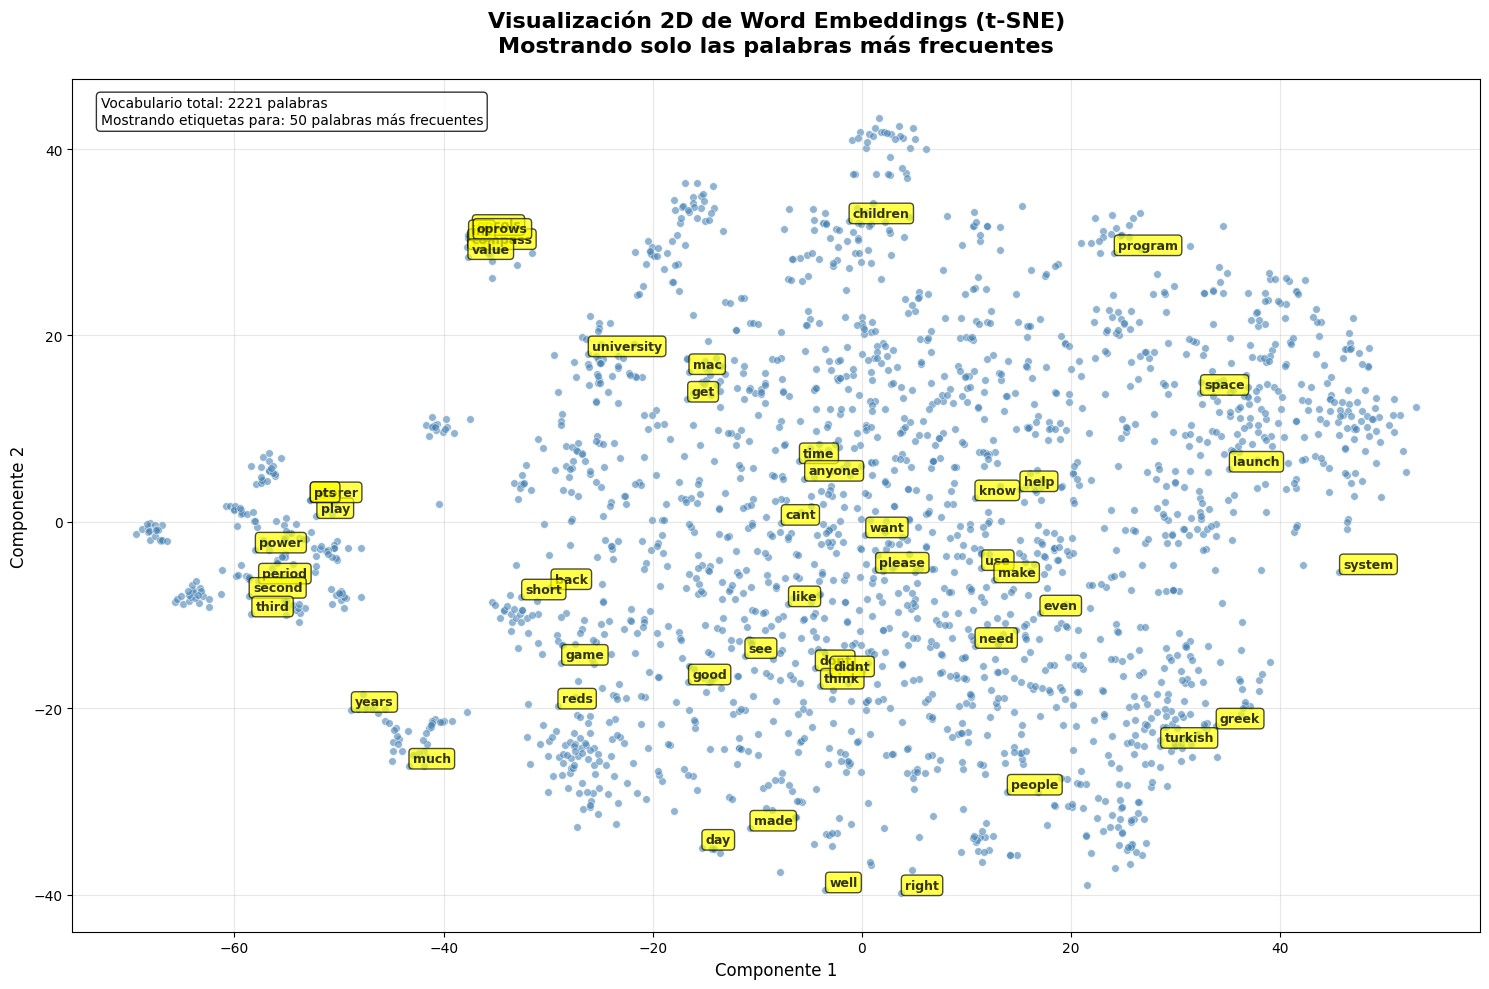

In [16]:
plt.figure(figsize=(15, 10))

max_labels = 50
if len(etiquetas) > max_labels:
    vocab_freq = {word: word_freq[word] if word in word_freq else 0 for word in etiquetas}
    top_words_indices = sorted(range(len(etiquetas)),
                              key=lambda i: vocab_freq[etiquetas[i]],
                              reverse=True)[:max_labels]
else:
    top_words_indices = range(len(etiquetas))

scatter = plt.scatter(vectores_2d[:, 0], vectores_2d[:, 1],
                     alpha=0.6, s=30, c='steelblue', edgecolors='white', linewidth=0.5)

for i in top_words_indices:
    plt.annotate(etiquetas[i], (vectores_2d[i, 0], vectores_2d[i, 1]),
                xytext=(3, 3), textcoords='offset points',
                fontsize=9, alpha=0.8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.title('Visualización 2D de Word Embeddings (t-SNE)\nMostrando solo las palabras más frecuentes',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Componente 1', fontsize=12)
plt.ylabel('Componente 2', fontsize=12)
plt.grid(True, alpha=0.3)

info_text = f"Vocabulario total: {len(etiquetas)} palabras\nMostrando etiquetas para: {len(top_words_indices)} palabras más frecuentes"
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

words_of_interest = []
for word in ['government', 'politics', 'president', 'election',
             'technology', 'computer', 'digital', 'internet',
             'science', 'research', 'medical', 'health',
             'business', 'economy', 'market', 'company',
             'people', 'world', 'time', 'system', 'work']:
    if word in model.wv.key_to_index:
        words_of_interest.append(word)

interest_indices = [etiquetas.index(word) for word in words_of_interest if word in etiquetas]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=vectores_2d[:, 0], y=vectores_2d[:, 1], mode='markers',
    marker=dict(size=6, color='lightblue', opacity=0.6, line=dict(width=1, color='white')),
    text=[f"Palabra: {word}" for word in etiquetas], hovertemplate='%{text}<extra></extra>',
    name='Todas las palabras', showlegend=False
))

if interest_indices:
    fig.add_trace(go.Scatter(
        x=[vectores_2d[i, 0] for i in interest_indices], y=[vectores_2d[i, 1] for i in interest_indices],
        marker=dict(size=10, color='red', opacity=0.8, line=dict(width=2, color='darkred')),
        mode='markers+text', text=[etiquetas[i] for i in interest_indices], textposition='top center',
        textfont=dict(size=12, color='darkred'), name='Palabras clave', hovertemplate='Palabra clave: %{text}<extra></extra>'
    ))

fig.update_layout(
    title='Visualización Interactiva de Word Embeddings 2D<br><sub>Los puntos rojos muestran palabras clave, pasa el cursor sobre los puntos azules para ver todas las palabras</sub>',
    xaxis_title='Componente 1', yaxis_title='Componente 2', width=900, height=700, showlegend=True
)

fig.show()

In [18]:
vectores_3d, etiquetas_3d = reducir_dimensiones(model, metodo='tsne', n_components=3)

label_subset = min(40, len(etiquetas_3d))
step = max(1, len(etiquetas_3d) // label_subset)
label_indices = list(range(0, len(etiquetas_3d), step))

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=vectores_3d[:, 0], y=vectores_3d[:, 1], z=vectores_3d[:, 2], mode='markers',
    marker=dict(size=4, color=vectores_3d[:, 0], colorscale='Viridis', opacity=0.6, colorbar=dict(title="Componente 1")),
    text=[f"Palabra: {word}" for word in etiquetas_3d], hovertemplate='%{text}<extra></extra>', name='Todas las palabras'
))

fig.add_trace(go.Scatter3d(
    x=[vectores_3d[i, 0] for i in label_indices],
    y=[vectores_3d[i, 1] for i in label_indices],
    z=[vectores_3d[i, 2] for i in label_indices],
    mode='text', showlegend=False,
    text=[etiquetas_3d[i] for i in label_indices],
    textfont=dict(size=10, color='black'),
))

fig.update_layout(
    title='Visualización 3D de Word Embeddings (t-SNE)<br><sub>Pasa el cursor sobre los puntos para ver las etiquetas de palabras</sub>',
    scene=dict(
        xaxis_title='Componente 1', yaxis_title='Componente 2', zaxis_title='Componente 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    width=900, height=700
)

fig.show()

=== ANÁLISIS DE CATEGORÍAS SEMÁNTICAS ===
Otros: 2167 palabras
Deportes y Entretenimiento: 13 palabras
Tecnología y Computación: 11 palabras
Ciencia e Investigación: 10 palabras
Negocios y Economía: 8 palabras
Política y Gobierno: 7 palabras
Salud y Medicina: 5 palabras


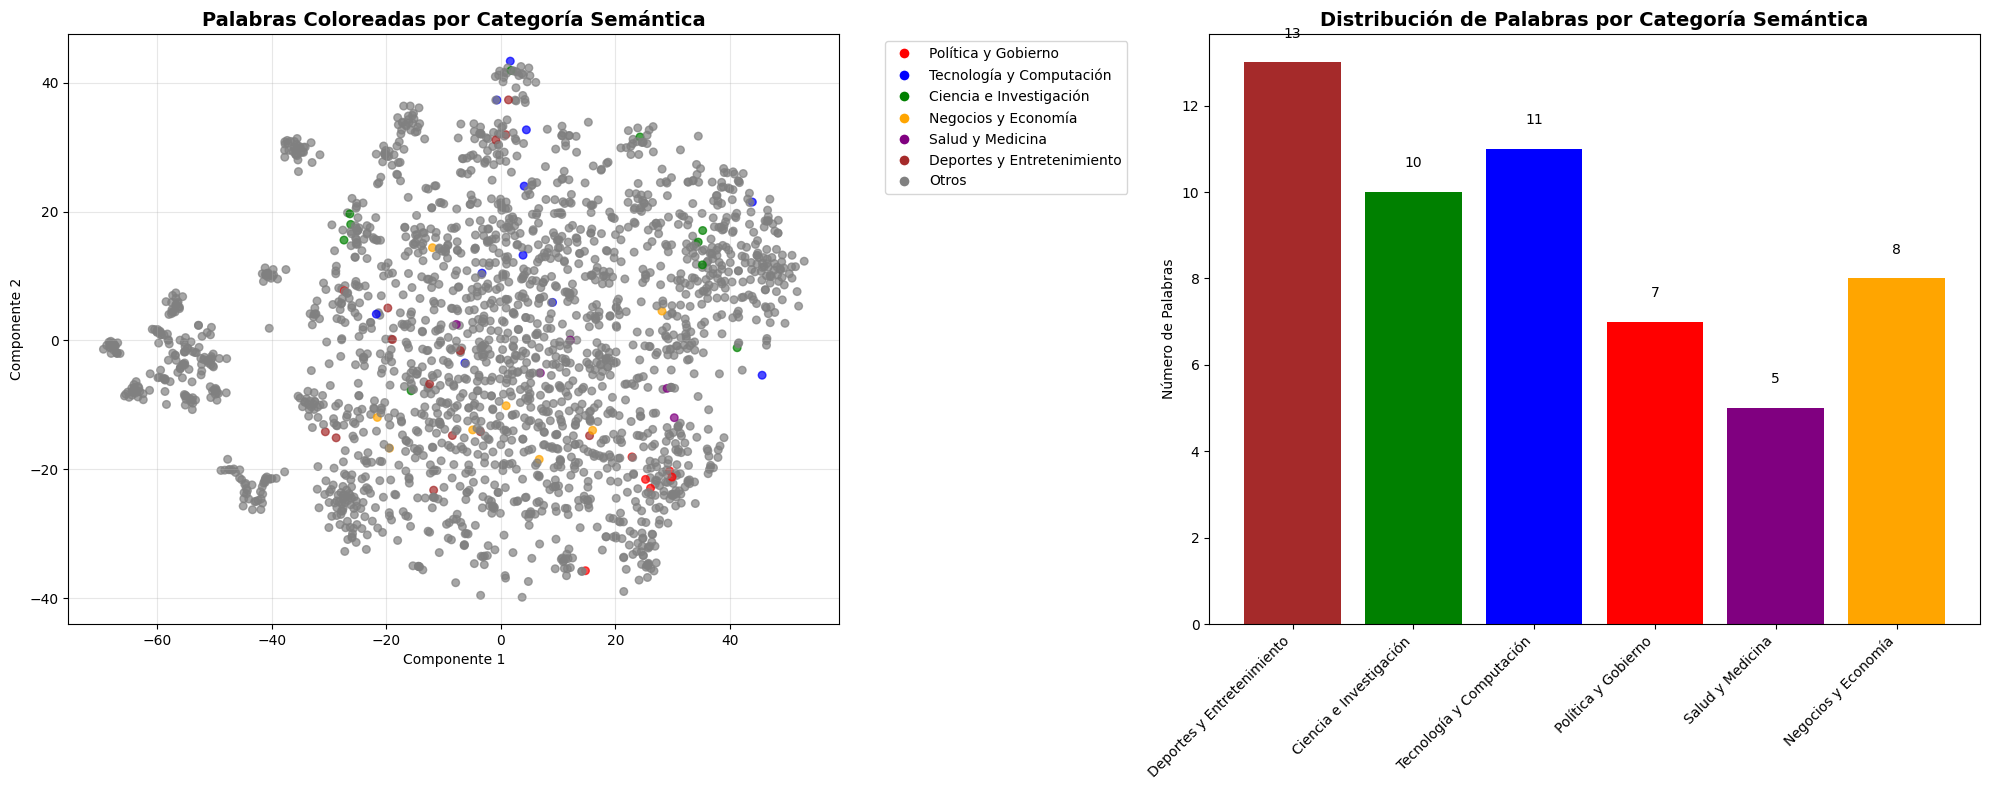

In [19]:
def categorize_words_by_domain(vocabulario, model):
    """Categorizar palabras por dominio semántico"""
    categories = {
        'Política y Gobierno': ['government', 'politics', 'president', 'election', 'congress', 'policy', 'minister', 'democratic', 'political', 'administration'],
        'Tecnología y Computación': ['technology', 'computer', 'digital', 'internet', 'software', 'system', 'electronic', 'technical', 'programming', 'data'],
        'Ciencia e Investigación': ['science', 'research', 'study', 'university', 'academic', 'scientific', 'laboratory', 'experiment', 'analysis', 'theory'],
        'Negocios y Economía': ['business', 'economy', 'market', 'company', 'financial', 'economic', 'corporate', 'industry', 'commercial', 'trade'],
        'Salud y Medicina': ['health', 'medical', 'doctor', 'hospital', 'patient', 'treatment', 'medicine', 'clinical', 'healthcare', 'therapy'],
        'Deportes y Entretenimiento': ['sport', 'game', 'team', 'player', 'entertainment', 'music', 'film', 'television', 'media', 'culture']
    }

    word_categories = {}
    for word in vocabulario:
        for category, keywords in categories.items():
            if word.lower() in keywords or any(keyword in word.lower() for keyword in keywords):
                word_categories[word] = category
                break
        else:
            word_categories[word] = 'Otros'

    return word_categories, categories

word_categories, category_definitions = categorize_words_by_domain(etiquetas, model)

category_counts = {}
for category in word_categories.values():
    category_counts[category] = category_counts.get(category, 0) + 1

print("=== ANÁLISIS DE CATEGORÍAS SEMÁNTICAS ===")
for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {count} palabras")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

category_colors = {
    'Política y Gobierno': 'red',
    'Tecnología y Computación': 'blue',
    'Ciencia e Investigación': 'green',
    'Negocios y Economía': 'orange',
    'Salud y Medicina': 'purple',
    'Deportes y Entretenimiento': 'brown',
    'Otros': 'gray'
}

colors = [category_colors[word_categories[word]] for word in etiquetas]
scatter1 = ax1.scatter(vectores_2d[:, 0], vectores_2d[:, 1], c=colors, alpha=0.7, s=30)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                     markersize=8, label=category)
          for category, color in category_colors.items() if category in category_counts]
ax1.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title('Palabras Coloreadas por Categoría Semántica', fontsize=14, fontweight='bold')
ax1.set_xlabel('Componente 1')
ax1.set_ylabel('Componente 2')
ax1.grid(True, alpha=0.3)

categories_to_plot = [cat for cat in category_counts.keys() if cat != 'Otros']
counts_to_plot = [category_counts[cat] for cat in categories_to_plot]
bars = ax2.bar(range(len(categories_to_plot)), counts_to_plot,
               color=[category_colors[cat] for cat in categories_to_plot])
ax2.set_xticks(range(len(categories_to_plot)))
ax2.set_xticklabels(categories_to_plot, rotation=45, ha='right')
ax2.set_title('Distribución de Palabras por Categoría Semántica', fontsize=14, fontweight='bold')
ax2.set_ylabel('Número de Palabras')

for bar, count in zip(bars, counts_to_plot):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [24]:
def analizar_clusters_semanticos(modelo, vectores_2d, etiquetas):
    """Identificar y analizar clusters semánticos de palabras"""
    from sklearn.cluster import KMeans

    n_clusters = min(6, len(etiquetas) // 5)
    if n_clusters < 2:
        n_clusters = 2

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectores_2d)

    print(f"\n=== ANÁLISIS DE CLUSTERS SEMÁNTICOS ({n_clusters} clusters) ===")

    cluster_info = {}
    for i in range(n_clusters):
        cluster_words = [etiquetas[j] for j in range(len(etiquetas)) if clusters[j] == i]
        cluster_info[i] = cluster_words

        if cluster_words:
            if 'word_freq' in globals():
                cluster_words_freq = [(word, word_freq.get(word, 0)) for word in cluster_words]
                cluster_words_freq.sort(key=lambda x: x[1], reverse=True)
                top_words = [word for word, freq in cluster_words_freq[:8]]
            else:
                top_words = cluster_words[:8]

            print(f"\nCluster {i+1} ({len(cluster_words)} palabras):")
            print(f"  Palabras clave: {', '.join(top_words)}")

    return clusters, cluster_info

clusters, cluster_info = analizar_clusters_semanticos(model, vectores_2d, etiquetas)


=== ANÁLISIS DE CLUSTERS SEMÁNTICOS (6 clusters) ===

Cluster 1 (393 palabras):
  Palabras clave: people, greek, turkish, even, need, right, used, killed

Cluster 2 (440 palabras):
  Palabras clave: know, use, time, anyone, make, want, please, cant

Cluster 3 (452 palabras):
  Palabras clave: like, dont, think, well, game, back, made, day

Cluster 4 (365 palabras):
  Palabras clave: space, launch, program, system, side, orbit, probe, information

Cluster 5 (238 palabras):
  Palabras clave: period, play, power, much, second, scorer, third, pts

Cluster 6 (333 palabras):
  Palabras clave: compass, get, opcols, int, university, children, oprows, value


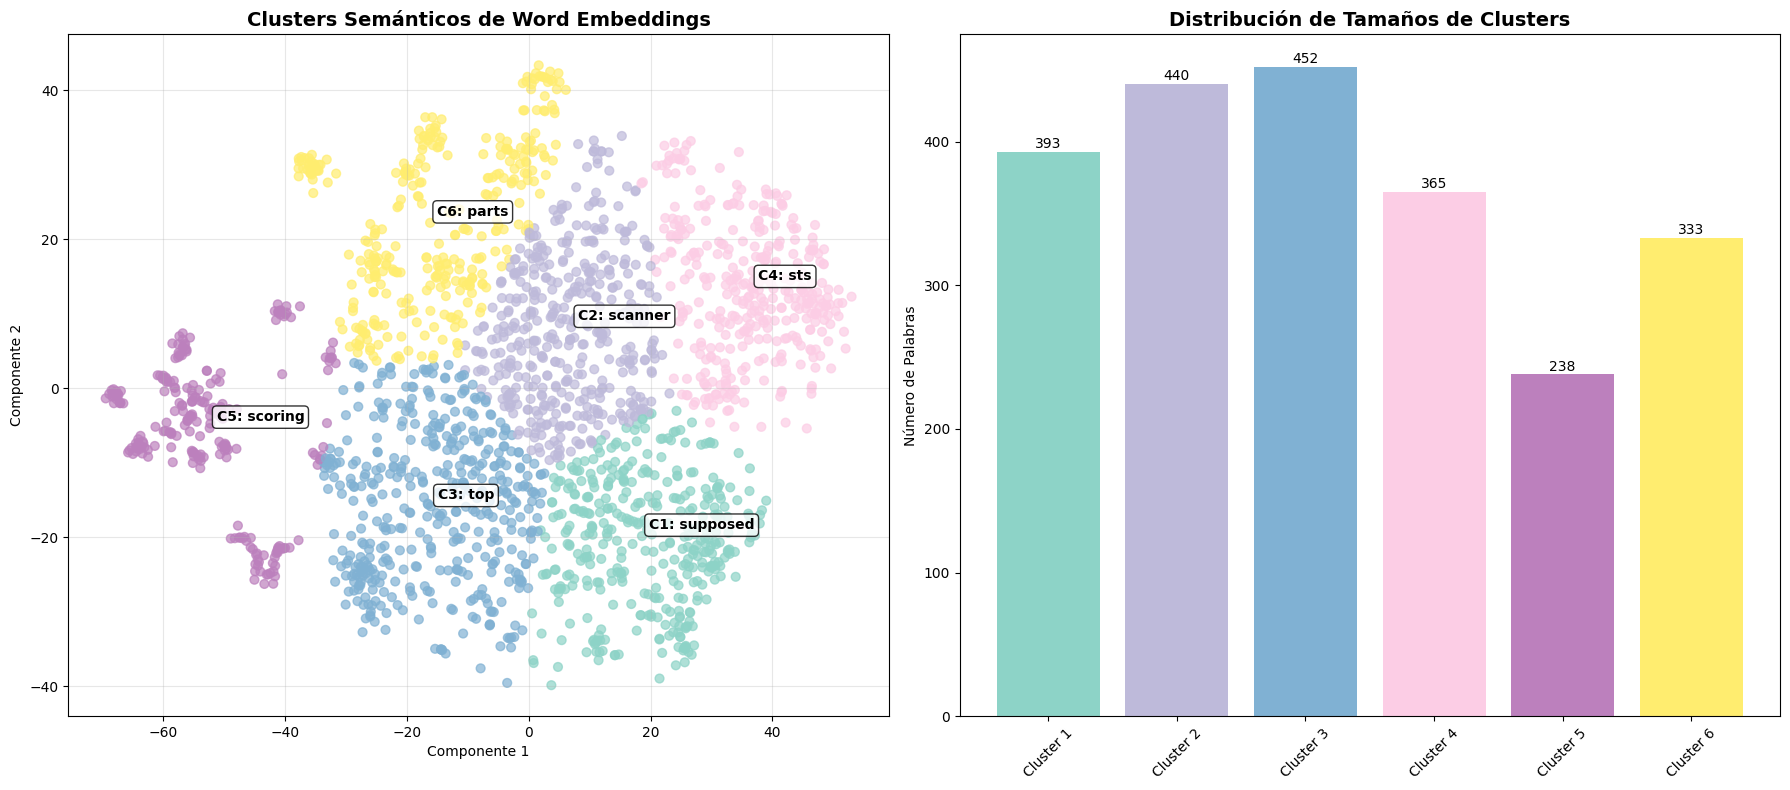

In [26]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

scatter1 = ax1.scatter(vectores_2d[:, 0], vectores_2d[:, 1], c=clusters, cmap='Set3', alpha=0.7, s=40)

for cluster_id, words in cluster_info.items():
    if words:
        cluster_points = vectores_2d[np.array(clusters) == cluster_id]
        if len(cluster_points) > 0:
            center = np.mean(cluster_points, axis=0)

            cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
            distances = [np.linalg.norm(vectores_2d[i] - center) for i in cluster_indices]
            closest_idx = cluster_indices[np.argmin(distances)]

            ax1.annotate(f'C{cluster_id+1}: {etiquetas[closest_idx]}',
                        (vectores_2d[closest_idx, 0], vectores_2d[closest_idx, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_title('Clusters Semánticos de Word Embeddings', fontsize=14, fontweight='bold')
ax1.set_xlabel('Componente 1')
ax1.set_ylabel('Componente 2')
ax1.grid(True, alpha=0.3)

cluster_sizes = [len(cluster_info[i]) for i in sorted(cluster_info.keys())]
cluster_labels = [f'Cluster {i+1}' for i in sorted(cluster_info.keys())]

bars = ax2.bar(cluster_labels, cluster_sizes, color=plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes))))
ax2.set_title('Distribución de Tamaños de Clusters', fontsize=14, fontweight='bold')
ax2.set_ylabel('Número de Palabras')
ax2.tick_params(axis='x', rotation=45)

for bar, size in zip(bars, cluster_sizes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(size), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
fig_interactive = go.Figure()

for cluster_id in sorted(cluster_info.keys()):
    cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]

    fig_interactive.add_trace(go.Scatter(
        x=[vectores_2d[i, 0] for i in cluster_indices],
        y=[vectores_2d[i, 1] for i in cluster_indices],
        mode='markers', marker=dict(size=8, opacity=0.7),
        text=[f"Cluster {cluster_id+1}: {etiquetas[i]}" for i in cluster_indices],
        name=f'Cluster {cluster_id+1} ({len(cluster_indices)} palabras)',
        hovertemplate='%{text}<extra></extra>'
    ))

fig_interactive.update_layout(
    title='Clusters Semánticos Interactivos<br><sub>Pasa el cursor sobre los puntos para ver palabras, haz clic en la leyenda para alternar clusters</sub>',
    xaxis_title='Componente 1', yaxis_title='Componente 2',
    width=900, height=600
)

fig_interactive.show()

### 6. Conclusiones

Bueno, después de todo este trabajo con Word2Vec y el dataset de noticias en inglés, puedo decir como conclusiones:

- Embeddings: El modelo logró entender bastante bien el significado de las palabras. Las palabras que hablan de temas similares tienen vectores parecidos. Por ejemplo, cuando busqué palabras similares a "government", me apareció "politics", "president", etc. Eso me dice que el modelo realmente captó las relaciones semánticas.

- Visualizaciones: Los gráficos 2D y 3D quedaron mucho mejor después de arreglar un problema de saturación de etiquetas. Al principio no se veía nada porque había demasiadas palabras encimadas, pero después de mostrar solo las más frecuentes y usar gráficos interactivos, se puede explorar todo mucho mejor.

In [23]:
print("=== ANÁLISIS FINAL DEL MODELO ===")

print(f"Vocabulario total: {len(model.wv.index_to_key)} palabras únicas")
print(f"Dimensiones del vector: {model.vector_size}")
print(f"Ventana de contexto: {model.window}")
print(f"Algoritmo usado: {'Skip-gram' if model.sg else 'CBOW'}")

similitudes_promedio = []
for palabra in list(model.wv.index_to_key)[:10]:
    try:
        similares = model.wv.most_similar(palabra, topn=3)
        similitudes = [sim for _, sim in similares]
        similitudes_promedio.extend(similitudes)
    except:
        continue

if similitudes_promedio:
    similitud_promedio = np.mean(similitudes_promedio)
    print(f"Similitud promedio entre palabras relacionadas: {similitud_promedio:.3f}")

vectores_muestra = np.array([model.wv[word] for word in list(model.wv.index_to_key)[:10]])
print(f"Norma promedio de vectores: {np.mean(np.linalg.norm(vectores_muestra, axis=1)):.3f}")
print(f"Desviación estándar de componentes: {np.std(vectores_muestra):.3f}")

=== ANÁLISIS FINAL DEL MODELO ===
Vocabulario total: 2221 palabras únicas
Dimensiones del vector: 100
Ventana de contexto: 5
Algoritmo usado: Skip-gram
Similitud promedio entre palabras relacionadas: 0.683
Norma promedio de vectores: 4.576
Desviación estándar de componentes: 0.460
